# KIT-Sch-GE (2) cell segmentation
Distance-transform-prediction-based segmentation method used for our submission to the 6th edition of the ISBI [Cell Tracking Challenge 2021](http://celltrackingchallenge.net/) as team [KIT-Sch-GE (2)](http://celltrackingchallenge.net/participants/KIT-Sch-GE/). 

The code is freely available at: https://git.scc.kit.edu/KIT-Sch-GE/2021_segmentation

This [Google Colab](https://colab.research.google.com/?utm_source=scs-index) notebook is intented for easy testing of our code, even without own hardware. To run and modify this notebook, save it to your Google Drive. 

---

Publications:

- T. Scherr, K. Löffler, M. Böhland, and R. Mikut (2020). Cell segmentation and tracking using CNN-based distance predictions and a graph-based matching strategy. PLoS ONE 15(12). DOI: [10.1371/journal.pone.0243219](https://doi.org/10.1371/journal.pone.0243219).
- K. Löffler, T. Scherr, and R. Mikut (2021). A graph-based cell tracking algorithm with few manually tunable parameters and automated segmentation error correction. PLoS ONE 16(9). DOI: [10.1371/journal.pone.0249257](https://doi.org/10.1371/journal.pone.0249257).
- T. Scherr, K. Löffler, O. Neumann, and R. Mikut (2021). On improving an already competitive segmentation algorithm for the cell tracking challenge - lessons learned. bioRxiv. DOI: [10.1101/2021.06.26.450019](https://doi.org/10.1101/2021.06.26.450019).

---
*If you only want to reproduce our results skip the sections 3 & 4.*

# 0. How to use this notebook
**Text cells** give instructions and provide information. They can be modified by double-clicking on the cell. **Code cells** contain code and can be modfied directly. Execute code cells by clicking a cell's play button which appears when your cursor is above the cell. When a code cell is finished, a green hook appears and (depending on the code) also an output, e.g., print messages.

To be able to use a GPU (which is highly recommended), you need to enable GPUs for this notebook:

- Navigate to Edit → Notebook Settings
- select GPU as Hardware Accelerator

Using some appropriate  hardware locally will decrease the training time significantly.

On the left side, you can find a table of contents and your files section. In the files section you can see your Google Drive files after mounting Google Drive (models and inference results will be saved into your drive):

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Installation
Most needed packages are already pre-installed in Colab. 

*Some package versions may differ from our requirements which can result in changes compared to running our code locally.*

## Install missing packages

In [2]:
!pip install imgaug==0.4.0 imagecodecs --no-dependencies

     |████████████████████████████████| 948 kB 5.2 MB/s 
     |████████████████████████████████| 31.0 MB 54.1 MB/s 
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


## Clone code repository

In [3]:
!git clone https://git.scc.kit.edu/KIT-Sch-GE/2021_segmentation.git

Cloning into '2021_segmentation'...
remote: Enumerating objects: 222, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 222 (delta 60), reused 94 (delta 35), pack-reused 89
Receiving objects: 100% (222/222), 242.39 KiB | 747.00 KiB/s, done.
Resolving deltas: 100% (86/86), done.


## Import all needed packages

In [4]:
import cv2
import numpy as np
import os
import random
import tifffile as tiff
import torch
import zipfile
import sys

from matplotlib import pyplot as plt
from pathlib import Path
from shutil import move, copyfile, copytree

sys.path.append('./2021_segmentation/')
from download_data import download_data
from segmentation.training.cell_segmentation_dataset import CellSegDataset
from segmentation.training.create_training_sets import create_ctc_training_sets, get_file, write_file
from segmentation.training.mytransforms import augmentors
from segmentation.training.training import train, get_max_epochs, get_weights
from segmentation.training.create_training_sets import get_file
from segmentation.utils import utils, unets
from segmentation.inference.inference import inference_2d_ctc, inference_3d_ctc
from segmentation.utils.metrics import count_det_errors, ctc_metrics
from eval import EvalArgs

random.seed()
np.random.seed()

## Get device
When you have chosen a GPU as hardware accelerator, the printed device should be "cuda":

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if str(device) == 'cuda':
  torch.backends.cudnn.benchmark = True
num_gpus = 1 if device.type == 'cuda' else 0
print(f"Device: {device}")

Device: cuda


# 2. Cell type selection and data download
Specify the cell type you are interested in for model training, evaluation and inference. Only the corresponding data set is downloaded from the Cell Tracking Challenge:

In [6]:
cell_type = 'Fluo-N2DL-HeLa'

Download the data and the evaluation software:

Unzip Fluo-N2DL-HeLa training set ...
Unzip Fluo-N2DL-HeLa challenge set ...
Unzip evaluation software ...


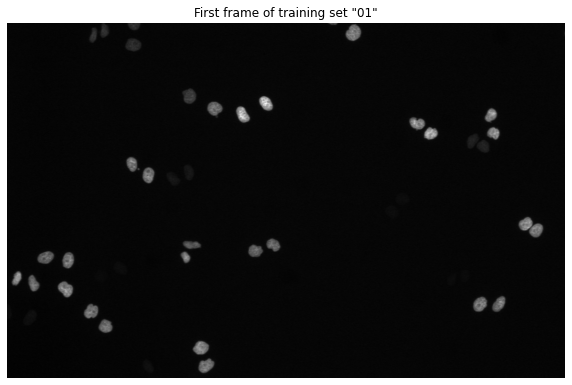

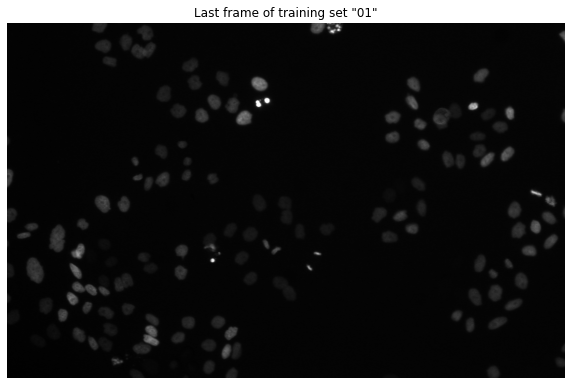

In [7]:
trainingdata_url = 'http://data.celltrackingchallenge.net/training-datasets/'
challengedata_url = 'http://data.celltrackingchallenge.net/challenge-datasets/'
evalsoftware_url = 'http://public.celltrackingchallenge.net/software/EvaluationSoftware.zip'

traindata_path = Path.cwd() / '2021_segmentation' / 'training_data'
challengedata_path = Path.cwd() / '2021_segmentation'/ 'challenge_data'
evalsoftware_path = Path.cwd() / '2021_segmentation' / 'evaluation_software'

# Download training set
if not (traindata_path / cell_type).is_dir():
  print('Downloading {} training set to /content/2021_segmentation/training_data ...'.format(cell_type))
  download_data(url="{}{}.zip".format(trainingdata_url, cell_type), target=traindata_path)

  # Unzip training set
  print('Unzip {} training set ...'.format(cell_type))
  with zipfile.ZipFile(traindata_path / "{}.zip".format(cell_type), 'r') as z:
      z.extractall('2021_segmentation/training_data')

# Download challenge set
if not (challengedata_path / cell_type).is_dir():
  print('Downloading {} challenge set /content/2021_segmentation/challenge_data ...'.format(cell_type))
  download_data(url="{}{}.zip".format(challengedata_url, cell_type), target=challengedata_path)

  # Unzip challenge set
  print('Unzip {} challenge set ...'.format(cell_type))
  with zipfile.ZipFile(challengedata_path / "{}.zip".format(cell_type), 'r') as z:
      z.extractall('2021_segmentation/challenge_data')

# Download evaluation software
if len(list(evalsoftware_path.glob('*'))) <= 1:
  print('Downloading evaluation software to /content/2021_segmentation/evaluation_software ...')
  download_data(url=evalsoftware_url, target=evalsoftware_path)

  # Unzip evaluation software
  print('Unzip evaluation software ...')
  with zipfile.ZipFile(evalsoftware_path / evalsoftware_url.split('/')[-1], 'r') as z:
      z.extractall('2021_segmentation/evaluation_software')

!chmod -R 755 2021_segmentation/evaluation_software/

# Open exemplary images (first and last frame from training set '01')
img_ids = sorted((traindata_path / cell_type / '01').glob('*.tif'))
img_0, img_1 = tiff.imread(str(img_ids[0])), tiff.imread(str(img_ids[-1]))
def visualize(image, title):
  # Divide all values by 65535 so we can display the image using matplotlib
  image = image / image.max()
  plt.figure(figsize=(10, 10))
  plt.axis('off')
  plt.title(title)
  plt.imshow(image, cmap='gray')

cmap_mask = plt.get_cmap("prism")
cmap_mask.set_bad(color="k")
def visualize_res(image, mask):
  # Divide all values by 65535 so we can display the image using matplotlib
  fig, axs = plt.subplots(1, 2, figsize=(12, 12))
  axs[0].imshow(np.squeeze(image), cmap='gray')
  axs[0].axis('off')
  mask = np.ma.masked_array(mask, mask==0)
  axs[1].imshow(np.squeeze(mask), cmap=cmap_mask)
  axs[1].axis('off')
  fig.tight_layout()
visualize(img_0, 'First frame of training set "01"')
visualize(img_1, 'Last frame of training set "01"')

If you want to use the KIT-Sch-GE (2) models for inference, download the models from the Cell Tracking Challenge website:

In [8]:
model_path = Path.cwd() / '2021_segmentation' / 'models' / 'kit-sch-ge'
model_url = 'http://public.celltrackingchallenge.net/participants/KIT-Sch-GE%20(2).zip'

# Download models
if len(list(model_path.glob('*.pth'))) == 0:
  print('Downloading models ...')
  download_data(url=model_url, target=model_path)

  # Unzip models
  print('Unzip models ...')
  with zipfile.ZipFile(model_path / model_url.split('/')[-1], 'r') as z:
      z.extractall('2021_segmentation/models/kit-sch-ge')

  # Move models
  for file_name in (model_path / 'KIT-Sch-GE (2)' / 'models').glob('*'):
      move(str(file_name), str(model_path))

print('KIT-Sch-GE (2) models available at /content/2021_segmentation/models/kit-sch-ge')


Unzip models ...
KIT-Sch-GE (2) models available at /content/2021_segmentation/models/kit-sch-ge


## Import models from Google Drive
*Note: only needed if former trained models stored on Google Drive should be evaluated*.

In [9]:
if Path('/content/drive/My Drive/kit-sch-ge_segmentation/models').is_dir():
  models = sorted(Path('/content/drive/My Drive/kit-sch-ge_segmentation/models').glob('*.pth'))
  if len(models) > 0:
    for model in models:
      copyfile(model,  Path.cwd() / f"2021_segmentation/models/all/{model.name}")
      copyfile(model.parent / f"{model.stem}.json",  Path.cwd() / f"2021_segmentation/models/all/{model.stem}.json")
  else:
    print("No models found")
else:
  print("No models found")

# 3. Training
*Skip this section if only inference with KIT-Sch-GE models is wanted.*

In this notebook only the training on a single cell type is supported. For training on multiple cell types and autoencoder pre-training take a look at the readme in our code repository.

For the training, 320px-by-320px crops are generated. For Cell Tracking Challenge GT data, the detection GT located in the TRA folder are used to examine if all cells in a crop are annotated. Only high quality crops are used (with some exceptions if too few crops are available). For the mixture of GT and ST, the amount of STs is limited. The final training sets with for training required distance transforms are saved into /content/2021_segmentation/training_data/ with a training set name consisting of the cell type, mode and split. If you want to train models on your own data or to apply trained models to your own data, you need to convert your data into the Cell Tracking Challenge format and add the data to /content/2021_segmentation/training_data/ (best put annotated masks into the GT folders SEG and TRA). Using the parameter `cell_type = "name_of_your_folder"` will create a training set with crop_size 320px-by-320px and train models with this set.

## Settings

In [10]:
# Arguments
act_fun = 'relu'  # activation function: 'relu' or 'mish' (recommended with ranger optimizer)
batch_size = 4  # reduce batch size if not enough vram available
filters = [64, 1024]  # u-net filters (minimum, maximum): best just keep
iterations = 1  # number of models to train' (best use 1 on Colab since GPU time is limited)
loss = 'smooth_l1'  # loss function: 'smooth_l1' (recommended), 'l1', 'l2'
mode = 'GT'  # Ground truth type / training mode: 'GT', 'ST', 'GT+ST'
norm_method = 'bn'  # Normalization layer type: 'bn'(recommended), 'gn', 'in'
optimizer = 'adam'  # Optimizer: 'adam' or 'ranger'
pool_method = 'conv'  # Pool method: 'conv' (recommended) or 'max'
split = '01+02'  # Train/val split: '01' (use data from training set "01" only), '02' or '01+02'
max_epochs = "auto"  # For smaller training times, use smaller amount ouf epochs, e.g., 50

## Create training data
Before the training process can start, the distance map labels need to be created and crops of size 320x320 need to be created. For some cell types and the 'ST' (silver truth) mode this can take some time.

In [11]:
# Paths
path_data = Path.cwd() / '2021_segmentation' / 'training_data'
path_models = Path.cwd() / '2021_segmentation' / 'models' / 'all'

# Model name
model_name = '{}_{}_{}_model'.format(cell_type, mode, split)
print(f"Model name: {model_name}")

# Check if training data already exist
if not (path_data / cell_type).exists():
    print(f'No data for cell type "{cell_type}" found. Please go back to section 2 and download the needed data')
else:
  # Create training sets
  print('Create training sets for {} ...'.format(cell_type))
  if mode == 'GT+ST':
      for hmode in ['GT', 'ST', 'GT+ST']:  # create needed GT & ST sets first
          create_ctc_training_sets(path_data=path_data, mode=hmode, cell_type_list=[cell_type], split=split)
  else:
      create_ctc_training_sets(path_data=path_data, mode=mode, cell_type_list=[cell_type], split=split)
print(f"Training data available at {path_data}/{cell_type}_{mode}_{split}")

Model name: Fluo-N2DL-HeLa_GT_01+02_model
Create training sets for Fluo-N2DL-HeLa ...
   ... create Fluo-N2DL-HeLa_GT_01+02 training set ...
Training data available at /content/2021_segmentation/training_data/Fluo-N2DL-HeLa_GT_01+02


Visualize some examples:



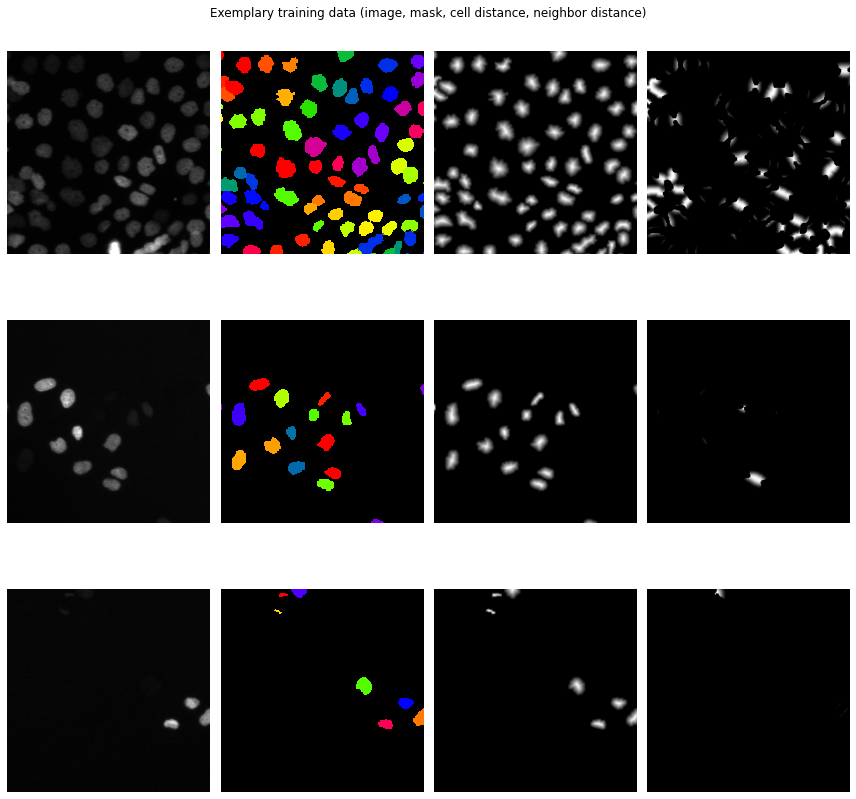

In [14]:
# Get train set cell distance maps
img_ids = (path_data / f"{cell_type}_{mode}_{split}" / 'train').glob('img*')
# Show 3 examples (image, mask, cell distance, neighbor distance)
images = []
for img_idx in img_ids:
  fname = img_idx.name.split('img')[-1]
  img = tiff.imread(str(img_idx))
  mask = tiff.imread(str(img_idx.parent / f"mask{fname}"))
  cell_dist = tiff.imread(str(img_idx.parent / f"dist_cell{fname}"))
  neighbor_dist = tiff.imread(str(img_idx.parent / f"dist_neighbor{fname}"))
  images.append([img, mask, cell_dist, neighbor_dist])
  if len(images) == 3:
    break

def visualize_train(images):
  cmap_mask = plt.get_cmap("prism")
  cmap_mask.set_bad(color="k")
  fig, axs = plt.subplots(len(images), 4, figsize=(12, 12))
  fig.suptitle('Exemplary training data (image, mask, cell distance, neighbor distance)')
  for i in range(len(images)):
    for j in range(4):
      if j == 1:
          mask = np.ma.masked_array(images[i][j], images[i][j]==0)
          axs[i, j].imshow(np.squeeze(mask), cmap=cmap_mask)
      else:
        axs[i, j].imshow(np.squeeze(images[i][j]), cmap='gray')
      axs[i, j].axis('off')
  fig.tight_layout()

visualize_train(images)

## Start training
This section starts the training process. When the validation loss improves, the model is saved.

In [ ]:
# Train models
for i in range(iterations):

    run_name = utils.unique_path(path_models, model_name + '_{:02d}.pth').stem

    # Get CNN (double encoder U-Net)
    train_configs = {'architecture': ("DU", pool_method, act_fun, norm_method, filters),
                     'batch_size': batch_size,
                     'label_type': "distance",
                     'loss': loss,
                     'num_gpus': num_gpus,
                     'optimizer': optimizer,
                     'run_name': run_name
                     }
    net = unets.build_unet(unet_type=train_configs['architecture'][0],
                           act_fun=train_configs['architecture'][2],
                           pool_method=train_configs['architecture'][1],
                           normalization=train_configs['architecture'][3],
                           device=device,
                           num_gpus=num_gpus,
                           ch_in=1,
                           ch_out=1,
                           filters=train_configs['architecture'][4])

    # Load training and validation set
    data_transforms = augmentors(label_type=train_configs['label_type'], min_value=0, max_value=65535)
    train_configs['data_transforms'] = str(data_transforms)
    dataset_name = "{}_{}_{}".format(cell_type, mode, split)
    datasets = {x: CellSegDataset(root_dir=path_data / dataset_name, mode=x, transform=data_transforms[x])
                for x in ['train', 'val']}

    # Get number of training epochs depending on dataset size (just roughly to decrease training time):
    if max_epochs == 'auto':
      train_configs['max_epochs'] = get_max_epochs(len(datasets['train']) + len(datasets['val']))
    else:
      train_configs['max_epochs'] = max_epochs

    # Train model
    best_loss = train(net=net, datasets=datasets, configs=train_configs, device=device, path_models=path_models)

    # Fine-tune with cosine annealing for Ranger models
    if train_configs['optimizer'] == 'ranger':
        net = unets.build_unet(unet_type=train_configs['architecture'][0],
                                act_fun=train_configs['architecture'][2],
                                pool_method=train_configs['architecture'][1],
                                normalization=train_configs['architecture'][3],
                                device=device,
                                num_gpus=num_gpus,
                                ch_in=1,
                                ch_out=1,
                                filters=train_configs['architecture'][4])
        # Get best weights as starting point
        net = get_weights(net=net, weights=str(path_models / '{}.pth'.format(run_name)), num_gpus=num_gpus, device=device)
        # Train further
        _ = train(net=net, datasets=datasets, configs=train_configs, device=device, path_models=path_models, best_loss=best_loss)

    # Write information to json-file
    utils.write_train_info(configs=train_configs, path=path_models)
    print(f"Model {run_name} saved at {path_models}")

--------------------
Train Fluo-N2DL-HeLa_GT_01+02_model_01 on 19 images, validate on 5 images
----------
Epoch 1/10
----------
Training loss: 0.20247
Validation loss: 0.02208
Validation loss improved from 10000.00000 to 0.02208. Save model.
Epoch training time: 46.3s
----------
Epoch 2/10
----------
Training loss: 0.04249
Validation loss: 0.02225
Validation loss did not improve.
Epoch     2: reducing learning rate of group 0 to 2.0000e-04.
Epoch training time: 10.3s
----------
Epoch 3/10
----------
Training loss: 0.02861
Validation loss: 0.02179
Validation loss improved from 0.02208 to 0.02179. Save model.
Epoch training time: 10.8s
----------
Epoch 4/10
----------
Training loss: 0.02271
Validation loss: 0.02068
Validation loss improved from 0.02179 to 0.02068. Save model.
Epoch training time: 10.8s
----------
Epoch 5/10
----------
Training loss: 0.02029
Validation loss: 0.01935
Validation loss improved from 0.02068 to 0.01935. Save model.
Epoch training time: 10.9s
----------
Epoch 6

## Export models
So far, the trained models are stored on Colab in /content/2021_segmentation/models/all/ and can be used for inference but they will be deleted after you close Colab. If you want to export the models to your Google Drive, execute the following code block:

In [15]:
Path('/content/drive/My Drive/kit-sch-ge_segmentation').mkdir(exist_ok=True)
Path('/content/drive/My Drive/kit-sch-ge_segmentation/models').mkdir(exist_ok=True)

models = path_models.glob('*.pth')
for model in models:
  if Path(f"/content/drive/My Drive/kit-sch-ge_segmentation/models/{model.stem}.json").is_file():
    print(f"{model.stem} already exists in Google Drive --> skip.")
  else:
    copyfile(model, f"/content/drive/My Drive/kit-sch-ge_segmentation/models/{model.name}")
    copyfile(model.parent / f"{model.stem}.json", f"/content/drive/My Drive/kit-sch-ge_segmentation/models/{model.stem}.json")
print('Models saved in Google Drive: /kit-sch-ge_segmentation/models/')

Fluo-N2DL-HeLa_GT+ST_model already exists in Google Drive --> skip.
Models saved in Google Drive: /kit-sch-ge_segmentation/models/


# 4. Evaluation
*Skip if no trained models are available.*

Trained models are evaluated on the selected training data subsets. The results of all evaluated models can be found in /content/2021_segmentation/training_data in the folder of the selected cell type (predictions and metric files 'DET_log.txt' and 'SEG_log.txt in the folders '01_RES_modelname' & '02_RES_modelname'). The name and the score of the best model is printed.

If you want to evaluate on your own data, the dataset name / cell type should include "2D" for 2D data and "3D" for 3D data.

## Settings

In [16]:
# Arguments
apply_merging = False  # merging post-processing (prevents oversegmentation)
artifact_correction = False  # artifact correction (only for BF-C2DL-HSC and BF-C2DL-MuSC)
batch_size = 4  # reduce batch size if not enough vram available
fuse_z_seeds = False  # fuse seeds in axial direction (only 3D data)
mode = 'GT'  # ground truth type used for evaluation: 'GT' or 'ST'
n_splitting = 40  # cell amount threshold to apply splitting post-processing (only 3D data)
scale = 1  # scale factor (can be found in the training data set info.json file, mostly 1)
subset = '01+02'  # subset to evaluate on: '01', '02', '01+02'
th_cell = 0.07  # threshold for adjusting cell size (mostly between 0.06 and 0.11)
th_seed = 0.45  # threshold for seed extraction (best use 0.45 or 0.35)

## Start evaluation

In [17]:
# Paths
path_data = Path.cwd() / '2021_segmentation' / 'training_data'
path_models = Path.cwd() / '2021_segmentation' / 'models' / 'all'
path_best_models = Path.cwd() / '2021_segmentation' / 'models' / 'best'
path_ctc_metric = Path.cwd() / '2021_segmentation' / 'evaluation_software'

# Check if training data already exist
if not (path_data / cell_type).exists():
    print(f'No data for cell type "{cell_type}" found. Please go back to section 2 and download the needed data')

# Check if evaluation metric is available
if not path_ctc_metric.is_dir():
    raise Exception('No evaluation software found. Please go back to section 2 and download the data and evaluation software')

# Get models to evaluate
models = sorted(path_models.glob("{}*.pth".format(cell_type)))
if len(models) == 0:
    raise Exception('No models to evaluate found.')

# Go through model list and evaluate for stated cell_types
results = {}
if subset in ['kit-sch-ge', '01+02']:
    results['01'] = []
    results['02'] = []
else:
    results[subset] = []

for model in models:
    train_sets = [subset]
    if subset in ['kit-sch-ge', '01+02']:
        train_sets = ['01', '02']
    for train_set in train_sets:
        print(f'Evaluate {model.stem} on {cell_type}_{train_set}: th_seed: {th_seed}, th_cell: {th_cell}')
        path_seg_results = path_data / cell_type / "{}_RES_{}".format(train_set, model.stem)
        path_seg_results.mkdir(exist_ok=True)
        # Get post-processing settings
        eval_args = EvalArgs(th_cell=float(th_cell), th_seed=float(th_seed), n_splitting=n_splitting, apply_clahe=False,
                             scale=scale, cell_type=cell_type, save_raw_pred=False, artifact_correction=artifact_correction, 
                             apply_merging=apply_merging, fuse_z_seeds=fuse_z_seeds)

        if '2D' in cell_type:
            inference_2d_ctc(model=model,
                             data_path=path_data / cell_type / train_set,
                             result_path=path_seg_results,
                             device=device,
                             batchsize=batch_size,
                             args=eval_args,
                             num_gpus=num_gpus)
        else:
            inference_3d_ctc(model=model,
                             data_path=path_data / cell_type / train_set,
                             result_path=path_seg_results,
                             device=device,
                             batchsize=batch_size,
                             args=eval_args,
                             num_gpus=num_gpus)

        seg_measure, det_measure = ctc_metrics(path_data=path_data / cell_type,
                                               path_results=path_seg_results,
                                               path_software=path_ctc_metric,
                                               subset=train_set,
                                               mode=mode)
        print(f'  DET: {det_measure}, SEG: {seg_measure}, OP_CSB: {(det_measure + seg_measure) / 2}')
        results[train_set].append([model.stem, det_measure, seg_measure, (det_measure + seg_measure) / 2])

# Get best model
overall_op_csb = []
if len(results) == 2:
  for i in range(len(results['01'])):
    overall_op_csb.append([(results['01'][i][-1] + results['02'][i][-1]) / 2, results['01'][i][0]])
else:
  for i in range(len(results[subset])):
    overall_op_csb.append([results[subset][i][-1], results[subset][i][0]])
overall_op_csb = sorted(overall_op_csb, key=lambda x: x[0], reverse=True)
print(f"Best model: {overall_op_csb[0][-1]} (OP_CSB: {overall_op_csb[0][0]}).")


Evaluate Fluo-N2DL-HeLa_GT+ST_model on Fluo-N2DL-HeLa_01: th_seed: 0.45, th_cell: 0.07
         ... processing t000 ...
         ... processing t001 ...
         ... processing t002 ...
         ... processing t003 ...
         ... processing t004 ...
         ... processing t005 ...
         ... processing t006 ...
         ... processing t007 ...
         ... processing t008 ...
         ... processing t009 ...
         ... processing t010 ...
         ... processing t011 ...
         ... processing t012 ...
         ... processing t013 ...
         ... processing t014 ...
         ... processing t015 ...
         ... processing t016 ...
         ... processing t017 ...
         ... processing t018 ...
         ... processing t019 ...
         ... processing t020 ...
         ... processing t021 ...
         ... processing t022 ...
         ... processing t023 ...
         ... processing t024 ...
         ... processing t025 ...
         ... processing t026 ...
         ... processin

# 5. Inference

The inference results can be found in content/challenge_datasets. Like for the training datasets, your own data need to be in the Cell Tracking Challenge format and be saved into /content/2021_segmentation/challenge_data into the folder of the selected cell type.

## Settings

In [18]:
# Arguments
model = "kit-sch-ge/Fluo-N2DL-HeLa_GT+ST_model"  # Model name for inference, e.g., "kit-sch-ge/Fluo-N2DL-HeLa_GT+ST_model" or "all/Fluo-N2DL-HeLa_GT_01+02_model_01"
apply_merging = False  # merging post-processing (prevents oversegmentation)
artifact_correction = False  # artifact correction (only for BF-C2DL-HSC and BF-C2DL-MuSC)
batch_size = 4  # reduce batch size if not enough vram available
fuse_z_seeds = False  # fuse seeds in axial direction (only 3D data)
n_splitting = 40  # cell amount threshold to apply splitting post-processing (only 3D data)
scale = 1  # scale factor (can be found in the training data set info.json file, mostly 1)
subset = '02'  # subset to process: '01', '02', '01+02'
th_cell = 0.07  # threshold for adjusting cell size (mostly between 0.06 and 0.11)
th_seed = 0.45  # threshold for seed extraction (best use 0.45 or 0.35)

## Start inference

In [19]:
# Paths
path_data = Path.cwd() / '2021_segmentation' / 'challenge_data'
path_models = Path.cwd() / '2021_segmentation' / 'models'

# Check if challenge data exist
if not (path_data / cell_type).exists():
    print(f'No data for cell type "{cell_type}" found. Please go back to section 2 and download the needed data')

# Load model
model = path_models / model
model = model.parent / f"{model.stem}.pth"

subsets = [subset]
if subset in ['kit-sch-ge', '01+02']:
    subsets = ['01', '02']

for infer_set in subsets:
    # Directory for results
    path_seg_results = path_data / cell_type / "{}_RES_{}".format(infer_set, model.stem)
    path_seg_results.mkdir(exist_ok=True)
    print(f'Inference using {model.stem} on {cell_type}_{infer_set}: th_seed: {th_seed}, th_cell: {th_cell}')
    # Check if results already exist
    if len(sorted(path_seg_results.glob('*.tif'))) > 0:
        print('   Segmentation results already exist (delete for new calculation).')
        continue

    inference_args = EvalArgs(th_cell=float(th_cell), th_seed=float(th_seed), n_splitting=n_splitting, apply_clahe=False,
                              scale=scale, cell_type=cell_type, save_raw_pred=False, artifact_correction=artifact_correction, 
                              apply_merging=apply_merging, fuse_z_seeds=fuse_z_seeds)

    if '2D' in cell_type:
        inference_2d_ctc(model=model,
                         data_path=path_data / cell_type / infer_set,
                         result_path=path_seg_results,
                         device=device,
                         batchsize=batch_size,
                         args=inference_args,
                         num_gpus=num_gpus)
    else:
        inference_3d_ctc(model=model,
                         data_path=path_data / cell_type / infer_set,
                         result_path=path_seg_results,
                         device=device,
                         batchsize=batch_size,
                         args=inference_args,
                         num_gpus=num_gpus)
        
    print(f'Inference results saved at {path_seg_results}.')


Inference using Fluo-N2DL-HeLa_GT+ST_model on Fluo-N2DL-HeLa_02: th_seed: 0.45, th_cell: 0.07
         ... processing t000 ...
         ... processing t001 ...
         ... processing t002 ...
         ... processing t003 ...
         ... processing t004 ...
         ... processing t005 ...
         ... processing t006 ...
         ... processing t007 ...
         ... processing t008 ...
         ... processing t009 ...
         ... processing t010 ...
         ... processing t011 ...
         ... processing t012 ...
         ... processing t013 ...
         ... processing t014 ...
         ... processing t015 ...
         ... processing t016 ...
         ... processing t017 ...
         ... processing t018 ...
         ... processing t019 ...
         ... processing t020 ...
         ... processing t021 ...
         ... processing t022 ...
         ... processing t023 ...
         ... processing t024 ...
         ... processing t025 ...
         ... processing t026 ...
         ... pr

## Visualize results
Best export the data and use fiji to view the results and to differentiate single instances.

First and last frame of training set "02"


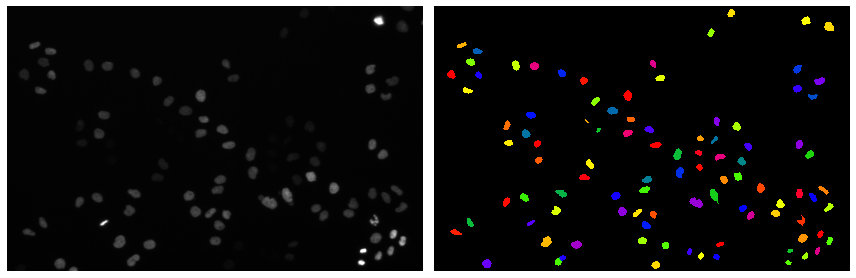

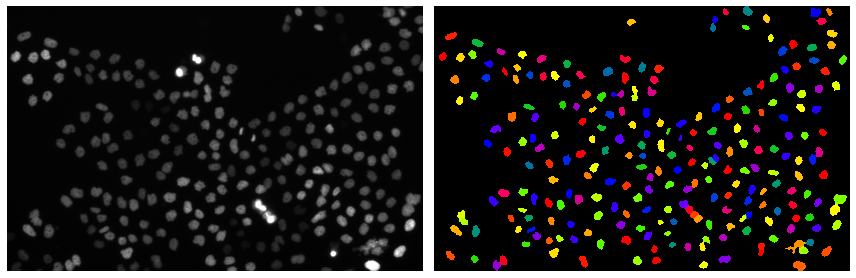

In [20]:
# Open exemplary images
cmap_mask = plt.get_cmap("prism")
cmap_mask.set_bad(color="k")
def visualize_res(image, mask):
  # Divide all values by 65535 so we can display the image using matplotlib
  fig, axs = plt.subplots(1, 2, figsize=(12, 12))
  axs[0].imshow(np.squeeze(image), cmap='gray')
  axs[0].axis('off')
  mask = np.ma.masked_array(mask, mask==0)
  axs[1].imshow(np.squeeze(mask), cmap=cmap_mask)
  axs[1].axis('off')
  fig.tight_layout()

for infer_set in subsets:
  mask_ids = sorted((path_data / cell_type / f"{infer_set}_RES_{model.stem}").glob('mask*.tif'))
  mask_0, mask_1 = tiff.imread(str(mask_ids[0])), tiff.imread(str(mask_ids[-1]))
  img_0 = tiff.imread(str(path_data / cell_type / f"{infer_set}" / f"t{mask_ids[0].stem.split('mask')[-1]}.tif"))
  img_1 = tiff.imread(str(path_data / cell_type / f"{infer_set}" / f"t{mask_ids[-1].stem.split('mask')[-1]}.tif"))
  print(f'First and last frame of training set "{infer_set}"')
  visualize_res(img_0, mask_0)
  visualize_res(img_1, mask_1)

## Zip and export results
This section zips the inference results and stores them on your Google Drive at /kit-sch-ge_segmentation/results.

In [21]:

Path('/content/drive/My Drive/kit-sch-ge_segmentation').mkdir(exist_ok=True)
Path('/content/drive/My Drive/kit-sch-ge_segmentation/results').mkdir(exist_ok=True)

for infer_set in subsets:

  # Zip folder path_data / cell_type / "{}_RES_{}".format(infer_set, model.stem)
  with zipfile.ZipFile(path_data / cell_type / f'{cell_type}_{infer_set}_RES_{model.stem}.zip', 'w') as z:
    z.write(path_data / cell_type / "{}_RES_{}".format(infer_set, model.stem), arcname="{}_RES_{}".format(infer_set, model.stem), compress_type=zipfile.ZIP_DEFLATED)
    for file_id in (path_data / cell_type / "{}_RES_{}".format(infer_set, model.stem)).glob('*'):
      z.write(file_id, arcname=os.path.join("{}_RES_{}".format(infer_set, model.stem), file_id.name),  compress_type=zipfile.ZIP_DEFLATED)
  
  # Copy to drive
  copyfile(path_data / cell_type / f'{cell_type}_{infer_set}_RES_{model.stem}.zip', f"/content/drive/My Drive/kit-sch-ge_segmentation/results/{cell_type}_{infer_set}_RES_{model.stem}.zip")

print('Results saved in Google Drive: /kit-sch-ge_segmentation/results/')

Results saved in Google Drive: /kit-sch-ge_segmentation/results/
